In [6]:
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import requests
from skimage.segmentation import slic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

%matplotlib inline

In [ ]:
# example from page: https://h1ros.github.io/posts/explain-the-prediction-for-imagenet-using-shap/

### Configuration

In [2]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1, 0, 100):
    colors.append((245 / 255, 39 / 255, 87 / 255, l))
for l in np.linspace(0, 1, 100):
    colors.append((24 / 255, 196 / 255, 93 / 255, l))
cm = LinearSegmentedColormap.from_list("shap", colors)

### Load pre-trained VGG16 model

In [7]:
# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16()

2021-12-07 14:42:07.319910: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-07 14:42:07.321217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-07 14:42:07.323642: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553467904/553467096 [==============================] - 103s 0us/step


### Load an image data

(224, 224, 3)


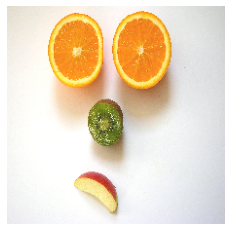

In [10]:
# load an image
file = "fruit.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)
plt.imshow(img)
plt.axis('off')
print(img_orig.shape)

### Segmentation

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


(-0.5, 223.5, 223.5, -0.5)

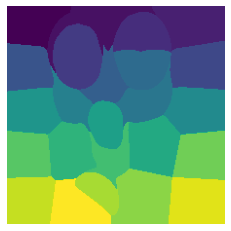

In [11]:
# Create segmentation to explain by segment, not every pixel
segments_slic = slic(img, n_segments=30, compactness=30, sigma=3)

plt.imshow(segments_slic)
plt.axis('off')

In [12]:
segments_slic

array([[ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       ...,
       [21, 21, 21, ..., 22, 22, 22],
       [21, 21, 21, ..., 22, 22, 22],
       [21, 21, 21, ..., 22, 22, 22]])

### Utility Functions for masking and preprocessing

In [13]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    
    if background is None:
        background = image.mean((0, 1))
        
    # Create an empty 4D array
    out = np.zeros((zs.shape[0], 
                    image.shape[0], 
                    image.shape[1], 
                    image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out


def f(z):
    return model.predict(
        preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

(-0.5, 223.5, 223.5, -0.5)

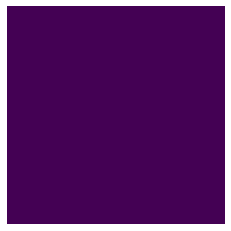

In [14]:
masked_images = mask_image(np.zeros((1,50)), segments_slic, img_orig, 255)

plt.imshow(masked_images[0][:,:, 0])
plt.axis('off')

### Create an explainer and shap values

In [15]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=100) # runs VGG16 1000 times

2021-12-07 14:54:25.404625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-07 14:54:25.409460: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


  0%|          | 0/1 [00:00<?, ?it/s]

### Obtain the prediction with the highest probability

In [16]:
predictions = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-predictions)

### Explain the prediction by visualization

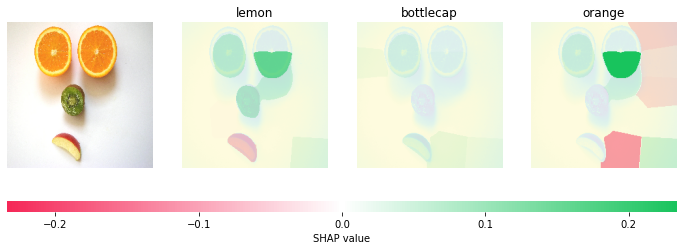

In [18]:
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(np.array(img.convert('LA'))[:, :, 0], alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

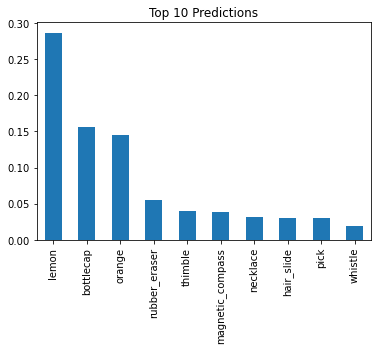

In [20]:
pd.Series(data={feature_names[str(inds[i])][1]:predictions[0, inds[i]]  for i in range(10)}).plot(kind='bar', title='Top 10 Predictions');